In [1]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from lmfit import Model
from pandas import read_csv
from PIL import Image

import os
spec_dir = os.path.abspath("./../spec/") + "/"
plots_dir = os.path.abspath('./../plots')+'/'

import sys
module_path = os.path.abspath("./../../module")
sys.path.append(module_path)
import redh3p as rhp

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter("ignore", category=AstropyWarning)

##################

fits_path_36 = spec_dir + "order36/jun02s*"
fits_path_35 = spec_dir + "order35/jun02s*"
fits_path_37 = spec_dir + "order37/jun02s*"
header_path = spec_dir + "jun02s*"

order36_data = rhp.read_fits(path=fits_path_36)
order35_data = rhp.read_fits(path=fits_path_35)
order37_data = rhp.read_fits(path=fits_path_37)

int0 = 22
flat0 = 32
flat1 = 41
dark0 = 22
dark1 = 31

avg_flat_order36 = rhp.calc_avg(data=order36_data, start=flat0, stop=flat1, init=int0)
avg_dark_order36 = rhp.calc_avg(data=order36_data, start=dark0, stop=dark1, init=int0)

avg_flat_order35 = rhp.calc_avg(data=order35_data, start=flat0, stop=flat1, init=int0)
avg_dark_order35 = rhp.calc_avg(data=order35_data, start=dark0, stop=dark1, init=int0)

avg_flat_order37 = rhp.calc_avg(data=order37_data, start=flat0, stop=flat1, init=int0)
avg_dark_order37 = rhp.calc_avg(data=order37_data, start=dark0, stop=dark1, init=int0)

spec36_reducelist = []
spec35_reducelist = []
spec37_reducelist = []

sky_frame = [51, 59, 60, 72, 78, 79, 91, 103]

for fn in range(60, 104):
    if fn in sky_frame:
        continue
    else:
        skyframe36 = rhp.scale_sky_frame(
            data=order36_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path
        )
        skyframe35 = rhp.scale_sky_frame(
            data=order35_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path
        )
        skyframe37 = rhp.scale_sky_frame(
            data=order37_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path
        )

        reduce_spec36 = (order36_data[fn - int0] - skyframe36) / (
            avg_flat_order36 - avg_dark_order36
        )
        reduce_spec36[reduce_spec36 < 0] = 0

        reduce_spec35 = (order35_data[fn - int0] - skyframe35) / (
            avg_flat_order35 - avg_dark_order35
        )
        reduce_spec35[reduce_spec35 < 0] = 0
        #         reduce_spec35 = np.delete(reduce_spec35, np.s_[:8], 0)

        reduce_spec37 = (order37_data[fn - int0] - skyframe37) / (
            avg_flat_order37 - avg_dark_order37
        )
        reduce_spec37[reduce_spec37 < 0] = 0
        #         reduce_spec37 = np.vstack((reduce_spec37, np.zeros((7, 1024))))

        spec36_reducelist.append(reduce_spec36)
        spec35_reducelist.append(reduce_spec35)
        spec37_reducelist.append(reduce_spec37)

spec36_reduced = np.array(spec36_reducelist)
spec35_reduced = np.array(spec35_reducelist)
spec37_reduced = np.array(spec37_reducelist)

waverange36 = fits.open(
    spec_dir + "order36/" + "waverange.fits", ignore_missing_end=True
)[0].data
waverange35 = fits.open(
    spec_dir + "order35/" + "waverange.fits", ignore_missing_end=True
)[0].data
waverange37 = fits.open(
    spec_dir + "order37/" + "waverange.fits", ignore_missing_end=True
)[0].data

R36 = 73194.84858495607
R35 = 73234.23454151815
R37 = 72736.04543958924
R = np.mean((R36, R35, R37))

# star flux calibration
modeA36 = (
    order36_data[104 - int0]
    + order36_data[107 - int0]
    + order36_data[108 - int0]
    + order36_data[111 - int0]
)
modeB36 = (
    order36_data[105 - int0]
    + order36_data[106 - int0]
    + order36_data[109 - int0]
    + order36_data[110 - int0]
)

modeA35 = (
    order35_data[104 - int0]
    + order35_data[107 - int0]
    + order35_data[108 - int0]
    + order35_data[111 - int0]
)
modeB35 = (
    order35_data[105 - int0]
    + order35_data[106 - int0]
    + order35_data[109 - int0]
    + order35_data[110 - int0]
)

modeA37 = (
    order37_data[104 - int0]
    + order37_data[107 - int0]
    + order37_data[108 - int0]
    + order37_data[111 - int0]
)
modeB37 = (
    order37_data[105 - int0]
    + order37_data[106 - int0]
    + order37_data[109 - int0]
    + order37_data[110 - int0]
)

exp_star = 25

modeAB36 = ((modeA36 - modeB36) / 4) / (avg_flat_order36 - avg_dark_order36) / exp_star

modeAB35 = ((modeA35 - modeB35) / 4) / (avg_flat_order35 - avg_dark_order35) / exp_star

modeAB37 = ((modeA37 - modeB37) / 4) / (avg_flat_order37 - avg_dark_order37) / exp_star

flux36_model = Model(rhp.gaussian_fit)
flux35_model = Model(rhp.gaussian_fit)
flux37_model = Model(rhp.gaussian_fit)

flux36_params = flux36_model.make_params()
flux36_params.add("a0", value=0.003, min=0, max=0.01)
flux36_params.add("a1", value=36)
flux36_params.add("a2", value=2, min=0.5, max=5)
flux36_params.add("a3", value=0)
flux36_params.add("a4", value=0)
flux36_params.add("a5", value=0)

flux35_params = flux35_model.make_params()
flux35_params.add("a0", value=0.003, min=0, max=0.01)
flux35_params.add("a1", value=42)
flux35_params.add("a2", value=2, min=0.5, max=5)
flux35_params.add("a3", value=0)
flux35_params.add("a4", value=0)
flux35_params.add("a5", value=0)

flux37_params = flux37_model.make_params()
flux37_params.add("a0", value=0.003, min=0, max=0.01)
flux37_params.add("a1", value=38)
flux37_params.add("a2", value=2, min=0.5, max=5)
flux37_params.add("a3", value=0)
flux37_params.add("a4", value=0)
flux37_params.add("a5", value=0)

lower = 0
upper = 1024

star36_a0 = np.zeros(np.size(modeAB36, 1))
star36_a2 = np.zeros(np.size(modeAB36, 1))

star35_a0 = np.zeros(np.size(modeAB35, 1))
star35_a2 = np.zeros(np.size(modeAB35, 1))

star37_a0 = np.zeros(np.size(modeAB37, 1))
star37_a2 = np.zeros(np.size(modeAB37, 1))

spat_ax36 = np.linspace(0, modeAB36.shape[0] - 1, modeAB36.shape[0])
spat_ax35 = np.linspace(0, modeAB35.shape[0] - 1, modeAB35.shape[0])
spat_ax37 = np.linspace(0, modeAB37.shape[0] - 1, modeAB37.shape[0])

for i in range(lower, upper):
    try:
        flux36_fit_result = flux36_model.fit(modeAB36.T[i], flux36_params, x=spat_ax36)
    except ValueError:
        print("ValueError occured at i=" + str(i) + " order36")

    try:
        flux35_fit_result = flux35_model.fit(modeAB35.T[i], flux35_params, x=spat_ax35)
    except ValueError:
        print("ValueError occured at i=" + str(i) + " order35")

    try:
        flux37_fit_result = flux37_model.fit(modeAB37.T[i], flux37_params, x=spat_ax37)
    except ValueError:
        print("ValueError occured at i=" + str(i) + " order37")

    star36_a0[i] = flux36_fit_result.params["a0"].value
    star36_a2[i] = flux36_fit_result.params["a2"].value

    star35_a0[i] = flux35_fit_result.params["a0"].value
    star35_a2[i] = flux35_fit_result.params["a2"].value

    star37_a0[i] = flux37_fit_result.params["a0"].value
    star37_a2[i] = flux37_fit_result.params["a2"].value

# compute calibration spectra
lambda_aw = 2.2  # mu m
hc_kb = 14388  # mu m K
T = 10000  # K

F_alpha_lyrae = 4.07e-10  # alpha Lyrae in atmospheric window 2.2 mu m
m_lambda = 6.749  # Kmag HD 131885
F_a0 = F_alpha_lyrae * 10 ** (-0.4 * m_lambda)

Fbb36 = (
    F_a0
    * ((lambda_aw / waverange36) ** 5)
    * ((np.exp(hc_kb / (lambda_aw * T)) - 1) / (np.exp(hc_kb / (waverange36 * T)) - 1))
)

Fbb35 = (
    F_a0
    * ((lambda_aw / waverange35) ** 5)
    * ((np.exp(hc_kb / (lambda_aw * T)) - 1) / (np.exp(hc_kb / (waverange35 * T)) - 1))
)

Fbb37 = (
    F_a0
    * ((lambda_aw / waverange37) ** 5)
    * ((np.exp(hc_kb / (lambda_aw * T)) - 1) / (np.exp(hc_kb / (waverange37 * T)) - 1))
)

star36_fwhm = star36_a2 * (np.sqrt(2 * np.log(2)) * 2)
Fobs36 = star36_a0 * star36_fwhm

star35_fwhm = star35_a2 * (np.sqrt(2 * np.log(2)) * 2)
Fobs35 = star35_a0 * star35_fwhm

star37_fwhm = star37_a2 * (np.sqrt(2 * np.log(2)) * 2)
Fobs37 = star37_a0 * star37_fwhm

Fc36 = Fbb36 / Fobs36

Fc35 = Fbb35 / Fobs35

Fc37 = Fbb37 / Fobs37

width36 = spec36_reduced.shape[1]
length36 = spec36_reduced.shape[2]

width35 = spec35_reduced.shape[1]
length35 = spec35_reduced.shape[2]

width37 = spec37_reduced.shape[1]
length37 = spec37_reduced.shape[2]

slit_area36 = 0.288 * width36 * 2.908e-5 * length36

slit_area35 = 0.288 * width35 * 2.999e-5 * length35

slit_area37 = 0.288 * width37 * 2.859e-5 * length37

exp_spec = 60

fjc36_list = []
fjc35_list = []
fjc37_list = []

for i in range(np.size(spec36_reduced, axis=0)):
    fjc36_list.append(spec36_reduced[i] / exp_spec * Fc36 * 4.2535e10 / slit_area36)
    fjc35_list.append(spec35_reduced[i] / exp_spec * Fc35 * 4.2535e10 / slit_area35)
    fjc37_list.append(spec37_reduced[i] / exp_spec * Fc37 * 4.2535e10 / slit_area37)

fjc36 = np.array(fjc36_list)
fjc35 = np.array(fjc35_list)
fjc37 = np.array(fjc37_list)


# rescale spatial axis
RA_modeA = 224.23866
RA_modeB = 224.24037
DEC_modeA = -26.28654
DEC_modeB = -26.28358

arcsec_diff_star = np.sqrt(
    ((RA_modeA - RA_modeB) * 3600) ** 2 + ((DEC_modeA - DEC_modeB) * 3600) ** 2
)
arcsec_per_pix_new = 0.1

star36_median = np.median((modeAB36.T[200:800, 20:220]), axis=0)
pix_diff_star36 = (
    np.where(star36_median == np.min(star36_median))[0][0]
    - np.where(star36_median == np.max(star36_median))[0][0]
)

star35_median = np.median((modeAB35.T[200:800, 20:220]), axis=0)
pix_diff_star35 = (
    np.where(star35_median == np.min(star35_median))[0][0]
    - np.where(star35_median == np.max(star35_median))[0][0]
)

star37_median = np.median((modeAB37.T[200:800, 20:220]), axis=0)
pix_diff_star37 = (
    np.where(star37_median == np.min(star37_median))[0][0]
    - np.where(star37_median == np.max(star37_median))[0][0]
)

zoom_fac36 = (arcsec_diff_star / arcsec_per_pix_new) / pix_diff_star36
zoom_fac35 = (arcsec_diff_star / arcsec_per_pix_new) / pix_diff_star35
zoom_fac37 = (arcsec_diff_star / arcsec_per_pix_new) / pix_diff_star37

fjc36_rs = scipy.ndimage.zoom(fjc36, [1, zoom_fac36, 1], mode="nearest")
fjc35_rs = scipy.ndimage.zoom(fjc35, [1, zoom_fac35, 1], mode="nearest")
fjc37_rs = scipy.ndimage.zoom(fjc37, [1, zoom_fac37, 1], mode="nearest")

fjc36_rs = np.delete(fjc36_rs, np.s_[260:], 1)
fjc35_rs = np.delete(fjc35_rs, np.s_[:14], 1)
fjc35_rs = np.delete(fjc35_rs, np.s_[260:], 1)

In [2]:
plots_dir = os.path.abspath('./../plots')+'/'
plots_dir

'/Users/ruoyanwang/Documents/leicester/h3p/02jun17/plots/'

BLANK LOOP START
DONE


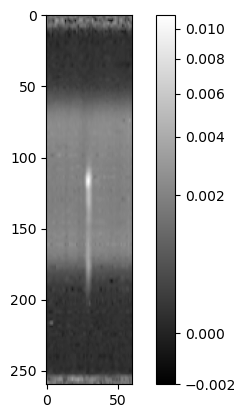

In [3]:
# smooth along wavelength axis - stacking multiple emission lines to enhance s/n ratio
st_list = []
# smooth = []
for i in range(np.size(fjc36_rs, axis=0)):
    # rs1a = np.delete(fjc36_rs[i], np.s_[800:], 1)
    # rs1b = np.delete(rs1a, np.s_[:700], 1)

    rs1a = np.delete(fjc36_rs[i], np.s_[450:], 1)
    rs1b = np.delete(rs1a, np.s_[:390], 1)

    # rs2a = np.delete(fjc32_rs[i], np.s_[700:], 1)
    # rs2b = np.delete(rs2a, np.s_[:600], 1)

    # rs3a = np.delete(fjc37_rs[i], np.s_[800:], 1)
    # rs3b = np.delete(rs3a, np.s_[:700], 1)

    # rs4a = np.delete(fjc35_rs[i], np.s_[500:], 1)
    # rs4b = np.delete(rs4a, np.s_[:400], 1)

    #     rs5a = np.delete(fjc34[i], np.s_[200:], 1)
    #     rs5b = np.delete(rs5a, np.s_[:100], 1)

    #     stt = rs1b+rs3b+rs4b
    stt = rs1b

    st_list.append(stt)
st = np.array(st_list)

# rs1a = np.delete(fjc36_rs[1], np.s_[800:], 1)
# rs1b = np.delete(rs1a, np.s_[:700], 1)

rs1a = np.delete(fjc36_rs[1], np.s_[450:], 1)
rs1b = np.delete(rs1a, np.s_[:390], 1)

rs3a = np.delete(fjc37_rs[1], np.s_[800:], 1)
rs3b = np.delete(rs3a, np.s_[:700], 1)

rs4a = np.delete(fjc35_rs[1], np.s_[500:], 1)
rs4b = np.delete(rs4a, np.s_[:400], 1)

plt.figure()
# plt.imshow(rs1b+rs3b+rs4b, cmap='gist_gray', norm=PowerNorm(gamma=0.4))
plt.imshow(rs1b, cmap="gist_gray", norm=colors.PowerNorm(gamma=0.4))
plt.colorbar()


# create empty list to collect result
background_scan = []

fn0 = 0
fn1 = np.size(st, 0)

upper = 250
lower = 10

print("BLANK LOOP START")
for fn in range(fn0, fn1):
    stack = st[fn]

    blank = np.zeros(300)

    # fit gaussian to selected range of spatial axis of a frame
    for i in range(lower, upper):
        blank[i] = np.max(stack[i])

    # Collect fitting parameters of each frame number
    background_scan.append(blank)

print("DONE")

BLANK LOOP START
DONE


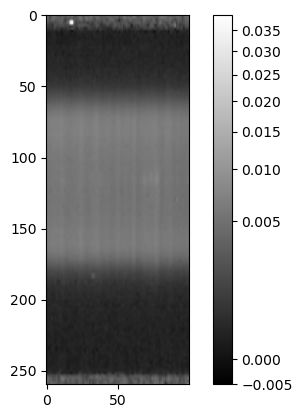

In [4]:
# smooth along wavelength axis - stacking multiple emission lines to enhance s/n ratio
st_list = []
# smooth = []
for i in range(np.size(fjc36_rs, axis=0)):
    rs1a = np.delete(fjc36_rs[i], np.s_[800:], 1)
    rs1b = np.delete(rs1a, np.s_[:700], 1)

    # rs1a = np.delete(fjc36_rs[i], np.s_[450:], 1)
    # rs1b = np.delete(rs1a, np.s_[:390], 1)

    #     rs2a = np.delete(fjc32[i], np.s_[700:], 1)
    #     rs2b = np.delete(rs2a, np.s_[:600], 1)

    rs3a = np.delete(fjc37_rs[i], np.s_[800:], 1)
    rs3b = np.delete(rs3a, np.s_[:700], 1)

    rs4a = np.delete(fjc35_rs[i], np.s_[500:], 1)
    rs4b = np.delete(rs4a, np.s_[:400], 1)

    #     rs5a = np.delete(fjc34[i], np.s_[200:], 1)
    #     rs5b = np.delete(rs5a, np.s_[:100], 1)

    stt = rs1b+rs3b+rs4b
    # stt = rs1b

    st_list.append(stt)
st = np.array(st_list)

rs1a = np.delete(fjc36_rs[1], np.s_[800:], 1)
rs1b = np.delete(rs1a, np.s_[:700], 1)

# rs1a = np.delete(fjc36_rs[1], np.s_[450:], 1)
# rs1b = np.delete(rs1a, np.s_[:390], 1)

rs3a = np.delete(fjc37_rs[1], np.s_[800:], 1)
rs3b = np.delete(rs3a, np.s_[:700], 1)

rs4a = np.delete(fjc35_rs[1], np.s_[500:], 1)
rs4b = np.delete(rs4a, np.s_[:400], 1)

plt.figure()
plt.imshow(rs1b+rs3b+rs4b, cmap='gist_gray', norm=colors.PowerNorm(gamma=0.4))
# plt.imshow(rs1b, cmap="gist_gray", norm=PowerNorm(gamma=0.4))
plt.colorbar()


# create empty list to collect result
background_scan = []

fn0 = 0
fn1 = np.size(st, 0)

upper = 250
lower = 10

print("BLANK LOOP START")
for fn in range(fn0, fn1):
    stack = st[fn]

    blank = np.zeros(301)

    # fit gaussian to selected range of spatial axis of a frame
    for i in range(lower, upper):
        blank[i] = np.median(stack[i])

    # Collect fitting parameters of each frame number
    background_scan.append(blank)

print("DONE")

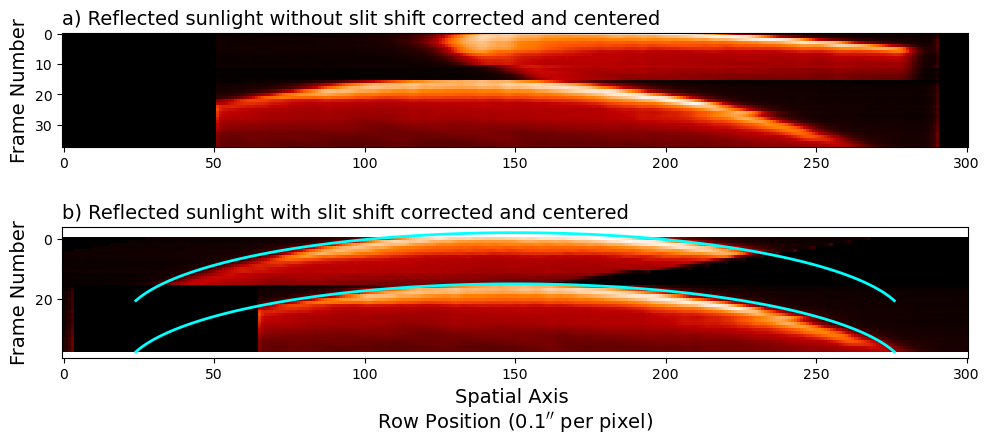

In [6]:
backgr_raw = np.vstack(background_scan)
# backgr_raw[16:][:,:20] = 1e-8
# backgr = np.delete(backgr, np.s_[132:], 1)
# backgr = np.delete(backgr, np.s_[:7], 1)

# backgr1 = np.roll(backgr_raw[:6], 13, axis=1)
# backgr2 = np.roll(backgr_raw[6:11], 12, axis=1)
# backgr3 = np.roll(backgr_raw[11:16], 20, axis=1)
# backgr4 = np.roll(backgr_raw[16:27], -14, axis=1)
# backgr5 = np.roll(backgr_raw[27:], -14, axis=1)

backgr1 = np.roll(backgr_raw[:6], 23, axis=1)
backgr2 = np.roll(backgr_raw[6:11], 22, axis=1)
backgr3 = np.roll(backgr_raw[11:16], 30, axis=1)
backgr4 = np.roll(backgr_raw[16:27], -14, axis=1)
backgr5 = np.roll(backgr_raw[27:], -14, axis=1)

backgr_shifted = np.vstack((backgr1, backgr2, backgr3, backgr4, backgr5))
# backgr_shifted = backgr_raw + 0

for i in range(16):
    backgr_shifted[i, :] = scipy.ndimage.shift(backgr_shifted[i, :], i * 6, order=3)

backgr_shifted2 = np.flip(backgr_shifted, 1)
backgr_raw2 = np.flip(backgr_raw, 1)

u = 150  # x-position of the center
v = 45  # y-position of the center
a = 130  # radius on the x-axis
b = 30  # radius on the y-axis

u2 = 150
v2 = 28
a2 = 130
b2 = 30

t = np.linspace(np.pi + 0.25, 2 * np.pi - 0.25, 100)

reback = np.array(Image.fromarray(backgr_shifted).resize(size=(301, 76)))


fig = plt.figure(figsize=(10, 5), tight_layout=True)

fig.add_subplot(211)
plt.imshow(backgr_raw2, aspect="equal", cmap="gist_heat", norm=colors.PowerNorm(gamma=1))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel("Frame Number", fontsize=14)
plt.title(
    "a) Reflected sunlight without slit shift corrected and centered",
    loc="left",
    fontsize=14,
)
# plt.colorbar(extend='max', aspect=15, pad=0.02, label='Median of background')

fig.add_subplot(212)
plt.imshow(backgr_shifted2, aspect="equal", cmap="gist_heat", norm=colors.PowerNorm(gamma=1))
plt.xlabel("Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)", fontsize=14)
plt.ylabel("Frame Number", fontsize=14)
plt.title(
    "b) Reflected sunlight with slit shift corrected and centered",
    loc="left",
    fontsize=14,
)

plt.plot(u + a * np.cos(t), v + b * np.sin(t), "cyan", lw=2)
plt.plot(u2 + a2 * np.cos(t), v2 + b2 * np.sin(t), "cyan", lw=2)

# plt.colorbar(extend="max", aspect=15, pad=0.02, label="Median of background")

# fig.add_subplot(313)
# plt.imshow(reback,
#            aspect='equal',
#            cmap='gist_heat',
#            extent=[-150, 150, 114.0669, 189.0669],
#            norm=colors.PowerNorm(gamma=1),
#           )
# plt.imshow(backgr_shifted, aspect='equal', cmap='gist_heat', norm=colors.PowerNorm(gamma=1))
# plt.plot(u+a*np.cos(t) , v+b*np.sin(t), 'cyan', lw=2)
# plt.plot(u2+a2*np.cos(t) , v2+b2*np.sin(t), 'cyan', lw=2)
# plt.xlabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ / pixel)')#x coordinate
# plt.ylabel('Temporal Axis \nRow Position (0.1$^{\prime\prime}$ / pixel)')#polar pixel radius y coordinate
# plt.title('c)', loc='left')

# plt.savefig('ref_sunlight.pdf', dpi=600, bbox_inches='tight', facecolor='white')

hdu1 = fits.PrimaryHDU(backgr_shifted2)
# hdu1.writeto('ref_sun.fits', overwrite=True)

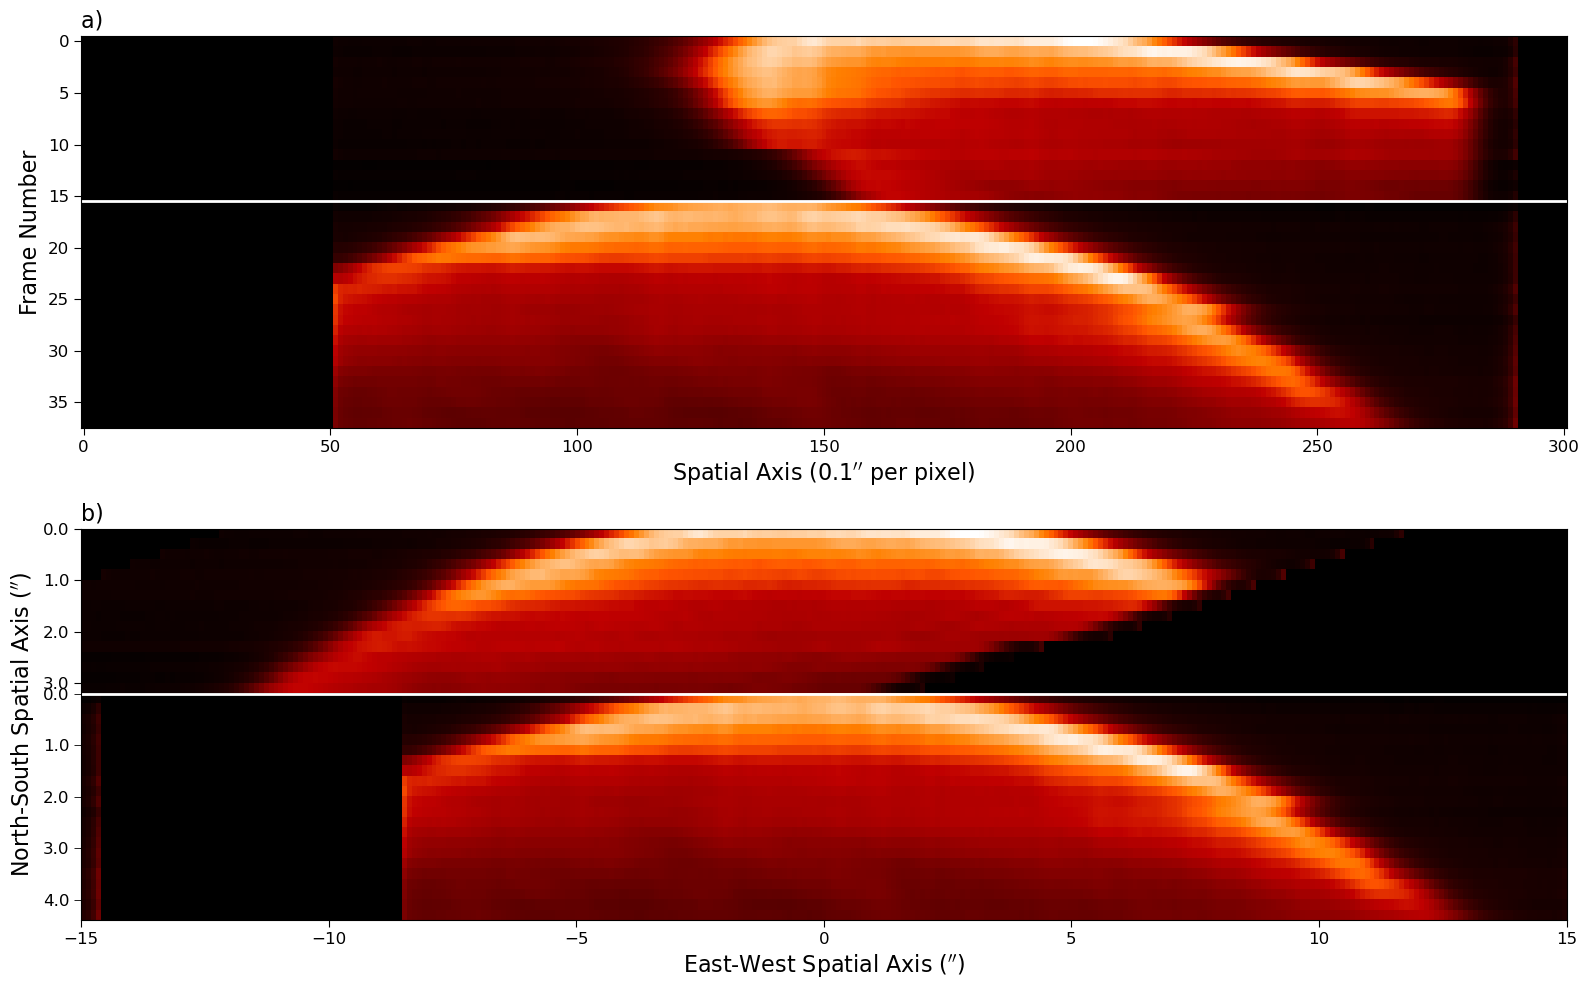

In [7]:
fig = plt.figure(figsize=(16,10), tight_layout=True)

ax1 = fig.add_subplot(2,1,1)
im1 = ax1.imshow(backgr_raw2, 
           # extent=[-15,15,7.6,0],
           aspect='auto', 
           cmap='gist_heat', 
           norm=colors.PowerNorm(gamma=1),
          )

ax1.set_xlabel('Spatial Axis (0.1$^{\prime\prime}$ per pixel)', fontsize=16)
ax1.set_ylabel('Frame Number', fontsize=16)
ax1.set_title('a) ', loc='left', fontsize=16)
# ax1.set_yticks([0, 1, 2, 3])
# ax1.set_yticklabels(['0.0', '1.0', '2.0', '3.0'])
ax1.tick_params(axis='y', length=5, which='major', labelsize='large')
# ax1.set_yticks([3.2, 4.2, 5.2, 6.2, 7.2], minor=True)
# ax1.set_yticklabels(['0.0','1.0','2.0','3.0','4.0'], minor=True)
ax1.tick_params(axis='y', length=5, which='minor', labelsize='large')
ax1.tick_params(axis='x', length=5, labelsize='large')
plt.axhline(y=15.5, color='white', ls='solid', lw=2)

ax2 = fig.add_subplot(2,1,2)
im2 = ax2.imshow(backgr_shifted2, 
           extent=[-15,15,7.6,0],
           aspect='auto', 
           cmap='gist_heat', 
           norm=colors.PowerNorm(gamma=1)
          )
ax2.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax2.set_ylabel('North-South Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax2.set_title('b)', loc='left', fontsize=16)
ax2.set_yticks([0, 1, 2, 3])
ax2.set_yticklabels(['0.0', '1.0', '2.0', '3.0'])
ax2.tick_params(axis='y', length=5, which='major', labelsize='large')
ax2.set_yticks([3.2, 4.2, 5.2, 6.2, 7.2], minor=True)
ax2.set_yticklabels(['0.0','1.0','2.0','3.0','4.0'], minor=True)
ax2.tick_params(axis='y', length=5, which='minor', labelsize='large')
ax2.tick_params(axis='x', length=5, labelsize='large')
plt.axhline(y=3.2, color='white', ls='solid', lw=2)

u = 0  # x-position of the center
v = 9.5  # y-position of the center
a = 15.5  # radius on the x-axis
b = 10  # radius on the y-axis

u2 = 0
v2 = 13
a2 = 15.5
b2 = 10

t = np.linspace(np.pi + 0.58, 2 * np.pi - 0.58, 100)

# plt.plot(u + a * np.cos(t), v + b * np.sin(t), "cyan", lw=2)
# plt.plot(u2 + a2 * np.cos(t), v2 + b2 * np.sin(t), "cyan", lw=2)

plt.savefig(plots_dir+"ref_sunlight", dpi=300, bbox_inches="tight")

In [69]:
plots_dir

'/Users/ruoyanwang/Documents/leicester/h3p/02jun17/plots/'

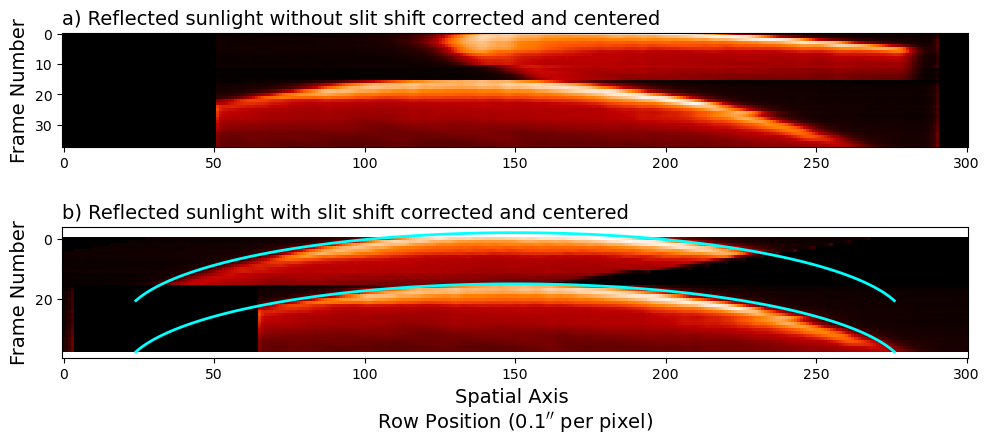

In [12]:
backgr_raw = np.vstack(background_scan)
# backgr_raw[16:][:,:20] = 1e-8
# backgr = np.delete(backgr, np.s_[132:], 1)
# backgr = np.delete(backgr, np.s_[:7], 1)

# backgr1 = np.roll(backgr_raw[:6], 13, axis=1)
# backgr2 = np.roll(backgr_raw[6:11], 12, axis=1)
# backgr3 = np.roll(backgr_raw[11:16], 20, axis=1)
# backgr4 = np.roll(backgr_raw[16:27], -14, axis=1)
# backgr5 = np.roll(backgr_raw[27:], -14, axis=1)

backgr1 = np.roll(backgr_raw[:6], 23, axis=1)
backgr2 = np.roll(backgr_raw[6:11], 22, axis=1)
backgr3 = np.roll(backgr_raw[11:16], 30, axis=1)
backgr4 = np.roll(backgr_raw[16:27], -14, axis=1)
backgr5 = np.roll(backgr_raw[27:], -14, axis=1)

backgr_shifted = np.vstack((backgr1, backgr2, backgr3, backgr4, backgr5))
# backgr_shifted = backgr_raw + 0

for i in range(16):
    backgr_shifted[i, :] = scipy.ndimage.shift(backgr_shifted[i, :], i * 6, order=3)

backgr_shifted2 = np.flip(backgr_shifted, 1)
backgr_raw2 = np.flip(backgr_raw, 1)

u = 150  # x-position of the center
v = 45  # y-position of the center
a = 130  # radius on the x-axis
b = 30  # radius on the y-axis

u2 = 150
v2 = 28
a2 = 130
b2 = 30

t = np.linspace(np.pi + 0.25, 2 * np.pi - 0.25, 100)

reback = np.array(Image.fromarray(backgr_shifted).resize(size=(301, 76)))


fig = plt.figure(figsize=(10, 5), tight_layout=True)

fig.add_subplot(211)
plt.imshow(backgr_raw2, aspect="equal", cmap="gist_heat", norm=PowerNorm(gamma=1))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel("Frame Number", fontsize=14)
plt.title(
    "a) Reflected sunlight without slit shift corrected and centered",
    loc="left",
    fontsize=14,
)
# plt.colorbar(extend='max', aspect=15, pad=0.02, label='Median of background')

fig.add_subplot(212)
plt.imshow(backgr_shifted2, aspect="equal", cmap="gist_heat", norm=PowerNorm(gamma=1))
plt.xlabel("Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)", fontsize=14)
plt.ylabel("Frame Number", fontsize=14)
plt.title(
    "b) Reflected sunlight with slit shift corrected and centered",
    loc="left",
    fontsize=14,
)

plt.plot(u + a * np.cos(t), v + b * np.sin(t), "cyan", lw=2)
plt.plot(u2 + a2 * np.cos(t), v2 + b2 * np.sin(t), "cyan", lw=2)

# plt.colorbar(extend="max", aspect=15, pad=0.02, label="Median of background")

# fig.add_subplot(313)
# plt.imshow(reback,
#            aspect='equal',
#            cmap='gist_heat',
#            extent=[-150, 150, 114.0669, 189.0669],
#            norm=PowerNorm(gamma=1),
#           )
# plt.imshow(backgr_shifted, aspect='equal', cmap='gist_heat', norm=colors.PowerNorm(gamma=1))
# plt.plot(u+a*np.cos(t) , v+b*np.sin(t), 'cyan', lw=2)
# plt.plot(u2+a2*np.cos(t) , v2+b2*np.sin(t), 'cyan', lw=2)
# plt.xlabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ / pixel)')#x coordinate
# plt.ylabel('Temporal Axis \nRow Position (0.1$^{\prime\prime}$ / pixel)')#polar pixel radius y coordinate
# plt.title('c)', loc='left')

# plt.savefig('ref_sunlight.pdf', dpi=600, bbox_inches='tight', facecolor='white')

hdu1 = fits.PrimaryHDU(backgr_shifted2)
# hdu1.writeto('ref_sun.fits', overwrite=True)

In [3]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.degrees(np.arctan2(y, x))
    return (rho, phi)


def pol2cart(rho, phi):
    x = rho * np.cos(np.radians(phi))
    y = rho * np.sin(np.radians(phi))
    return (x, y)


def slit_to_lat_long(x, y, jup_pixel_radius, jup_seangle, jup_posangle, jup_cml):
    jup_posangle2 = (720 - jup_posangle) % 360.0

    latit = np.zeros(5)
    longit = np.zeros(5)

    ccc = np.zeros(5)
    ppp = np.zeros(5)
    xxx = np.zeros(5)
    yyy = np.zeros(5)

    R = jup_pixel_radius

    # do a lat and long for each corner of pixel
    for corner in range(5):
        if corner == 0:
            x2 = x + 0.5
            y2 = y + 0.5
        if corner == 1:
            x2 = x + 0.5
            y2 = y - 0.5
        if corner == 2:
            x2 = x - 0.5
            y2 = y - 0.5
        if corner == 3:
            x2 = x - 0.5
            y2 = y + 0.5
        if corner == 4:
            x2 = x
            y2 = y

        # rotate the pixels into jovian rotational coordinates
        polar = cart2pol(x2, y2)
        new_polar = jup_posangle2 + polar[1]
        rect2 = pol2cart(polar[0], new_polar)

        xx = rect2[0]

        # stretch yy to become a sphere
        flattening = 0.06487
        losflattening = flattening * (1 - np.sin(np.radians(jup_seangle)))
        eq_po_ratio = 1 - losflattening

        yy = rect2[1] / eq_po_ratio

        pp = np.sqrt(xx**2 + yy**2)  # proper distance from centre

        if pp / R < 0.998 and pp >= 1e-5:
            cc = np.arcsin(pp / R)  # angular distance from centre

            ccc[corner] = cc
            ppp[corner] = pp
            xxx[corner] = xx
            yyy[corner] = yy

            lat_left = np.cos(cc) * np.sin(np.deg2rad(jup_seangle))
            lat_right = yy * np.sin(cc) * np.cos(np.deg2rad(jup_seangle)) / pp
            latit[corner] = np.arcsin(lat_left + lat_right)

            long_top = xx * np.sin(cc)
            long_bot1 = pp * np.cos(np.deg2rad(jup_seangle)) * np.cos(cc)
            long_bot2 = yy * np.sin(np.deg2rad(jup_seangle)) * np.sin(cc)

            longit[corner] = np.deg2rad(jup_cml) - np.arctan(
                long_top / (long_bot1 - long_bot2)
            )

    return np.rad2deg(latit), np.rad2deg(longit)


def pix_assign_lat_long(x, y, jup_pixel_radius, jup_seangle, jup_cml):
    latit = np.zeros(5)
    longit = np.zeros(5)

    R = jup_pixel_radius

    flattening = 0.06487

    losflattening = flattening * (1 - np.sin(np.deg2rad(jup_seangle)))
    eq_po_ratio = 1 - losflattening

    r = np.sqrt(x**2 + (y / eq_po_ratio) ** 2)
    # r = np.sqrt(x**2 + y**2)

    if r / R < 0.998 and r >= 1e-5:
        theta = np.arcsin(r / R)

        long_top = x * np.sin(theta)
        long_bot1 = r * np.cos(np.deg2rad(jup_seangle)) * np.cos(theta)
        long_bot2 = y * np.sin(np.deg2rad(jup_seangle)) * np.sin(theta)

        lat_left = (y * np.sin(theta) * np.cos(np.deg2rad(jup_seangle))) / r
        lat_right = np.cos(theta) * np.sin(np.deg2rad(jup_seangle))

        longit[4] = np.deg2rad(jup_cml) - np.arctan(long_top / (long_bot1 - long_bot2))
        latit[4] = np.arcsin(lat_left + lat_right)

    return np.rad2deg(latit), np.rad2deg(longit)

In [8]:
flattening = 0.06487
losflattening = flattening * (1 - np.sin(np.deg2rad(-3.098)))
eq_po_ratio = 1 - losflattening
eq_po_ratio

0.9316241684804366

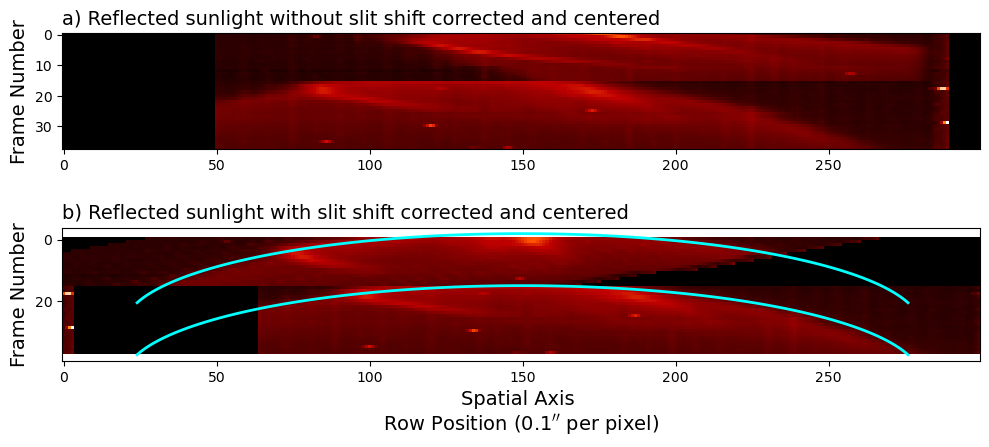

In [7]:
backgr_raw = np.vstack(background_scan)
# backgr_raw[16:][:,:20] = 1e-8
# backgr = np.delete(backgr, np.s_[132:], 1)
# backgr = np.delete(backgr, np.s_[:7], 1)

# backgr1 = np.roll(backgr_raw[:6], 13, axis=1)
# backgr2 = np.roll(backgr_raw[6:11], 12, axis=1)
# backgr3 = np.roll(backgr_raw[11:16], 20, axis=1)
# backgr4 = np.roll(backgr_raw[16:27], -14, axis=1)
# backgr5 = np.roll(backgr_raw[27:], -14, axis=1)

backgr1 = np.roll(backgr_raw[:6], 23, axis=1)
backgr2 = np.roll(backgr_raw[6:11], 22, axis=1)
backgr3 = np.roll(backgr_raw[11:16], 30, axis=1)
backgr4 = np.roll(backgr_raw[16:27], -14, axis=1)
backgr5 = np.roll(backgr_raw[27:], -14, axis=1)

backgr_shifted = np.vstack((backgr1, backgr2, backgr3, backgr4, backgr5))
# backgr_shifted = backgr_raw + 0

for i in range(16):
    backgr_shifted[i, :] = scipy.ndimage.shift(backgr_shifted[i, :], i * 6, order=3)

backgr_shifted2 = np.flip(backgr_shifted, 1)
backgr_raw2 = np.flip(backgr_raw, 1)

u = 150  # x-position of the center
v = 45  # y-position of the center
a = 130  # radius on the x-axis
b = 30  # radius on the y-axis

u2 = 150
v2 = 28
a2 = 130
b2 = 30

t = np.linspace(np.pi + 0.25, 2 * np.pi - 0.25, 100)

reback = np.array(Image.fromarray(backgr_shifted).resize(size=(301, 76)))


fig = plt.figure(figsize=(10, 5), tight_layout=True)

fig.add_subplot(211)
plt.imshow(backgr_raw2, aspect="equal", cmap="gist_heat", norm=PowerNorm(gamma=0.4))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel("Frame Number", fontsize=14)
plt.title(
    "a) Reflected sunlight without slit shift corrected and centered",
    loc="left",
    fontsize=14,
)
# plt.colorbar(extend='max', aspect=15, pad=0.02, label='Median of background')

fig.add_subplot(212)
plt.imshow(backgr_shifted2, aspect="equal", cmap="gist_heat", norm=PowerNorm(gamma=0.4))
plt.xlabel("Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)", fontsize=14)
plt.ylabel("Frame Number", fontsize=14)
plt.title(
    "b) Reflected sunlight with slit shift corrected and centered",
    loc="left",
    fontsize=14,
)

plt.plot(u + a * np.cos(t), v + b * np.sin(t), "cyan", lw=2)
plt.plot(u2 + a2 * np.cos(t), v2 + b2 * np.sin(t), "cyan", lw=2)

# plt.colorbar(extend="max", aspect=15, pad=0.02, label="Median of background")

# fig.add_subplot(313)
# plt.imshow(reback,
#            aspect='equal',
#            cmap='gist_heat',
#            extent=[-150, 150, 114.0669, 189.0669],
#            norm=PowerNorm(gamma=1),
#           )
# plt.imshow(backgr_shifted, aspect='equal', cmap='gist_heat', norm=colors.PowerNorm(gamma=1))
# plt.plot(u+a*np.cos(t) , v+b*np.sin(t), 'cyan', lw=2)
# plt.plot(u2+a2*np.cos(t) , v2+b2*np.sin(t), 'cyan', lw=2)
# plt.xlabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ / pixel)')#x coordinate
# plt.ylabel('Temporal Axis \nRow Position (0.1$^{\prime\prime}$ / pixel)')#polar pixel radius y coordinate
# plt.title('c)', loc='left')

# plt.savefig('ref_sunlight.pdf', dpi=600, bbox_inches='tight', facecolor='white')

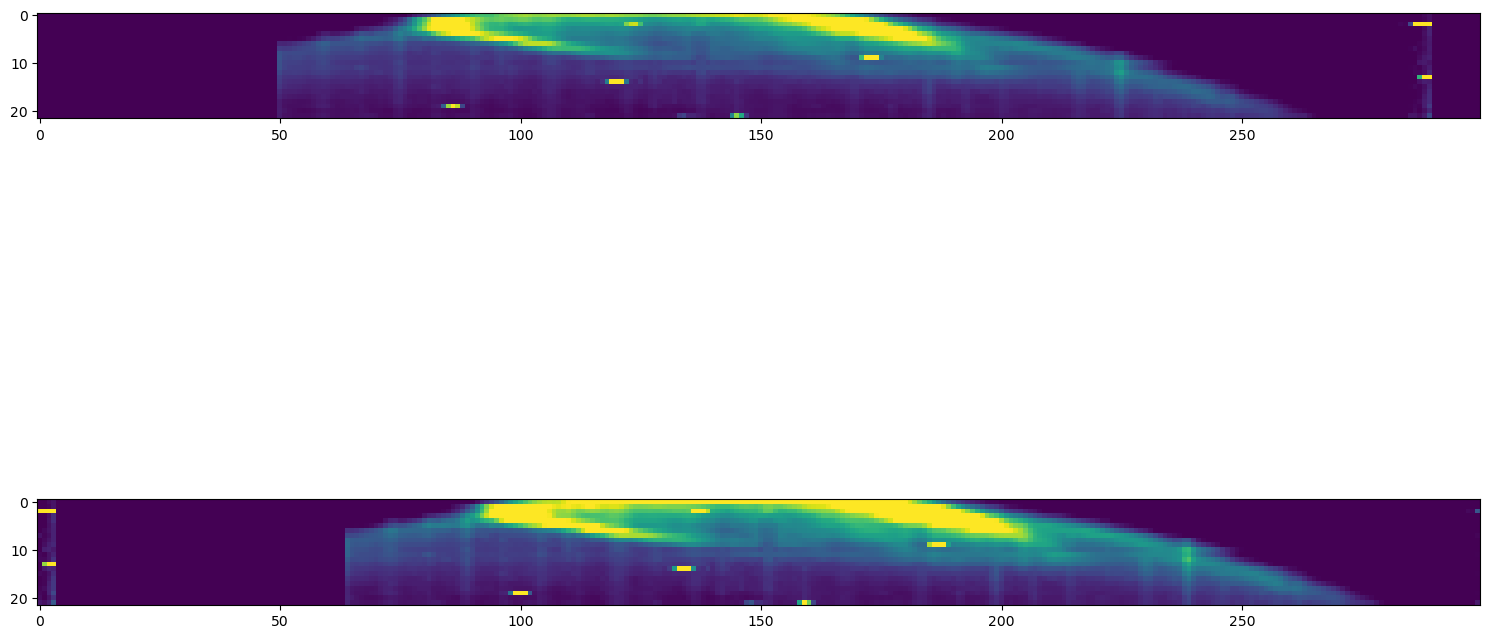

In [27]:
h2_int = fits.open("h2_int_v2.fits", ignore_missing_end=True)[0].data
h3p_int = fits.open("h3p_int_v2.fits", ignore_missing_end=True)[0].data


fig = plt.figure(figsize=(15, 8), tight_layout=True, facecolor="white")

fig.add_subplot(311)
plt.imshow(backgr_raw2[16:], vmin=0.0005, vmax=0.005)

# fig.add_subplot(312)
# plt.imshow()

fig.add_subplot(313)
plt.imshow(backgr_shifted2[16:], vmin=0.0005, vmax=0.004)

In [20]:
22 * 0.174 / 0.1

38.279999999999994

In [18]:
141 * 0.288 / 0.1

406.0799999999999

In [25]:
(122.5 / 113 * eq_po_ratio)

1.009946554326137

In [28]:
ang_diam = 40.58867
r = ang_diam / (0.183) / 2
r

110.89800546448087

In [36]:
ang_diam = 40.5
r = ang_diam * eq_po_ratio / (0.1) / 2
r, r * 0.65, r * 0.82

(188.65389411728842, 122.62503117623747, 154.69619317617648)

In [41]:
cmlsel = read_csv("cml-sel.txt", sep="\s+", header=None)
cml = cmlsel[3].to_numpy()

sub_sub_earth_lat = -3.098

ang_diam = 40.58867
r = ang_diam / (0.1) / 2

north_pole_posangle = 0

init_x = 150  # - (15.5 * 0.183) / 0.1  # 150
init_y = 182  # (99.5 * 0.183) / 0.2  # 188

x_arr = []
y_arr = []

dat = backgr_shifted2[16:]

lat_array = np.zeros([dat.shape[0], dat.shape[1]])
lon_array = np.zeros([dat.shape[0], dat.shape[1]])

for j in range(dat.shape[0]):
    for i in range(dat.shape[1]):
        x = i - init_x
        y = init_y - (0.174 / 0.1 * j)  # * (0.288 / 0.2)

        x_arr.append(x)
        y_arr.append(y)

        lat, lon = slit_to_lat_long(
            x, y, r, sub_sub_earth_lat, north_pole_posangle, cml[j + 16]
        )

        lat_array[j][i] = lat[4]
        lon_array[j][i] = lon[4]

176.352449
177.561468
178.165977
179.374996
180.584016
181.188525
182.397544
183.606563
184.211073
185.420092
186.629111
188.442639
189.651658
190.860677
191.465186
192.674205
193.883224
194.487733
195.696752
196.905771
197.51028
198.719299


In [1]:
79.5 * 0.183 / 0.1

145.48499999999999

In [37]:
99.5 * 0.183 / 0.1

182.085

In [37]:
print(y_arr[0], y_arr[-1])

182.0 145.46


In [54]:
init_x, init_y

(50.30208333333333, 91.0425)

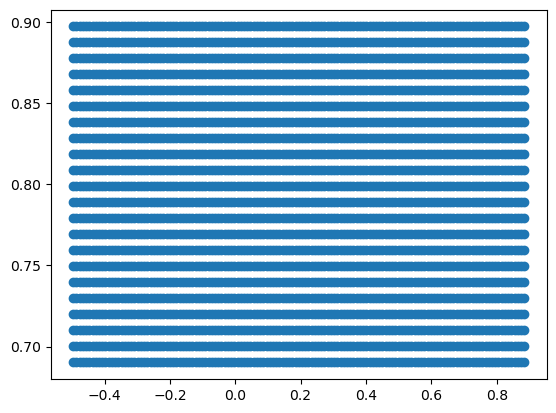

In [51]:
plt.scatter(np.array(x_arr) / r, np.array(y_arr) / r)

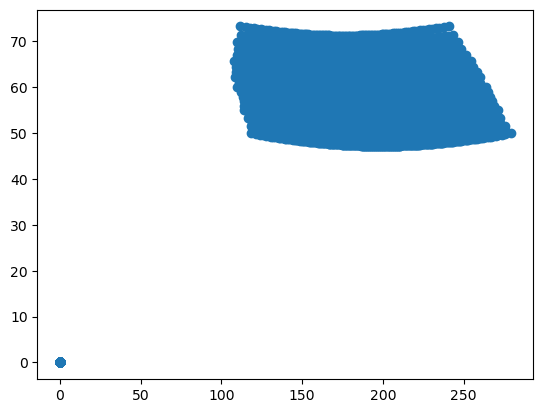

In [42]:
plt.scatter(lon_array, lat_array)

In [17]:
0 - (99.5 / 0.183) * 0.288

-156.59016393442624

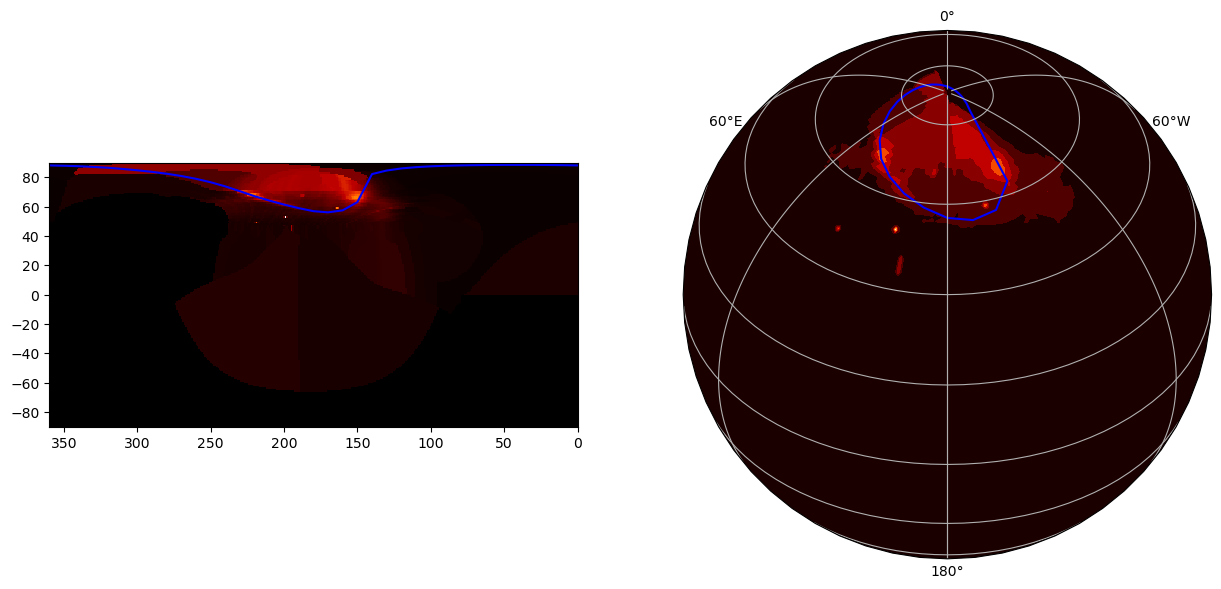

In [43]:
from pyresample.geometry import SwathDefinition
from pyresample import kd_tree, image
import cartopy.crs as ccrs

iospot = read_csv("grodent_iospot.dat", sep="\s+", header=None)
main_oval = read_csv("grodent_main_ovals.dat", sep="\s+", header=None)

main_oval_lat = main_oval[1].to_numpy()
main_oval_long = main_oval[0].to_numpy()

io_lat = iospot[1].to_numpy()
io_long = iospot[0].to_numpy()

map_long = np.array(lon_array)
map_latt = np.array(lat_array)

grid_latt, grid_long = np.mgrid[-90:90:181j, -180:180:361j]
# print(los.shape, las.shape)
map_long[map_long > 180] -= 360

source_def = SwathDefinition(lons=map_long, lats=map_latt)
target_def = SwathDefinition(lons=grid_long, lats=grid_latt)

im = backgr_shifted2[16:]

mapped = kd_tree.resample_nearest(
    source_def, im, target_def, radius_of_influence=4e7, epsilon=0.5
)

rolled_map = np.roll(mapped, 180, axis=1)

rolled_map2 = np.roll(rolled_map, 22, axis=1)

# fig, ax = plt.subplots()

# ax.imshow(rolled_map, interpolation='none', origin='lower', extent=[0,360,-90,90], cmap='gist_heat')
# ax.set(xlim=(360,0))
# ax.plot(main_oval_long, main_oval_lat, c='b', ls='-')

fig = plt.figure(figsize=(15, 10))

ax1 = plt.subplot(121)
ax1.imshow(
    rolled_map,
    interpolation="none",
    origin="lower",
    extent=[0, 360, -90, 90],
    cmap="gist_heat",
)
ax1.set(xlim=(360, 0))
ax1.plot(main_oval_long, main_oval_lat, c="b", ls="-")


# ax2 = plt.subplot(132, projection='polar')
# ax2.imshow(rolled_map, interpolation='none', cmap='gist_heat')
# ax2.plot(main_oval_long, main_oval_lat, c='b', ls='-')

data_crs = ccrs.PlateCarree()

lon = np.linspace(0, 360, 361)
lat = np.linspace(-90, 90, 181)

ax3 = plt.subplot(122, projection=ccrs.Orthographic(180, 40))
# ax3.imshow(rolled_map, interpolation='none', origin='lower', extent=[0,360,-90,90], cmap='gist_heat')

ax3.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="b", ls="-")
ax3.contourf(360 - lon, lat, rolled_map, transform=data_crs, cmap="gist_heat")
gl = ax3.gridlines(draw_labels=True)

In [38]:
cml

array([153.985589, 155.194609, 156.403628, 157.008138, 158.217158,
       159.426177, 160.030687, 161.239707, 162.448726, 163.053236,
       164.262255, 166.075784, 167.284804, 168.493823, 169.098333,
       170.307352, 176.352449, 177.561468, 178.165977, 179.374996,
       180.584016, 181.188525, 182.397544, 183.606563, 184.211073,
       185.420092, 186.629111, 188.442639, 189.651658, 190.860677,
       191.465186, 192.674205, 193.883224, 194.487733, 195.696752,
       196.905771, 197.51028 , 198.719299])

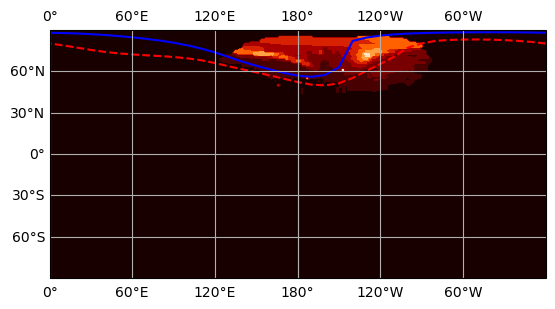

In [48]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# h3p_div2 = fits.open(plots_dir+'h3p_div_x150_y187_t.fits', ignore_missing_end=True)[0].data

iospot = read_csv("grodent_iospot.dat", sep="\s+", header=None)
main_oval = read_csv("grodent_main_ovals.dat", sep="\s+", header=None)

main_oval_lat = main_oval[1].to_numpy()
main_oval_long = main_oval[0].to_numpy()
# main_oval_latt = main_oval[2].to_numpy()

io_lat = iospot[1].to_numpy()
io_long = iospot[0].to_numpy()

lon = np.linspace(0, 360, 361)
lat = np.linspace(-90, 90, 181)

data_crs = ccrs.PlateCarree()

# lon2d, lat2d = np.meshgrid(lon, lat)

# data = np.cos(np.deg2rad(lat2d) * 4) + np.sin(np.deg2rad(lon2d) * 4)

# fig = plt.figure(figsize=(15,8), tight_layout=True, facecolor='white')

# fig.add_subplot(211)

plt.figure()
# ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax = plt.axes(projection=ccrs.PlateCarree(180))
# ax = plt.axes(projection=ccrs.Orthographic(180,90))
ax.set_global()

# ax.contourf(360-lon, lat, rolled_map, transform=data_crs, cmap='gist_heat')
ax.imshow()
ax.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="b", ls="-")
# ax.plot(360-main_oval_long-25, main_oval_lat+8, transform=data_crs, c='b', ls='-')
# ax.plot(np.degrees(new_long)[0], np.degrees(new_lat)[0], transform=data_crs, c='r', ls='-')
ax.plot(360 - io_long, io_lat, transform=data_crs, c="r", ls="--")
# ax.imshow(scan2)
# ax.set_extent([120, 240, 50, 90], crs=ccrs.PlateCarree())
# ax.set_extent([0, 43, 54, 75])
# lower left corner: latitude = 54, longitude = 0 upper right corner: latitude = 75, longitude = 43
# ax.coastlines(resolution='110m')
gl = ax.gridlines(draw_labels=True)
# gl.top_labels = True
# gl.right_labels = True
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)

# ax.set_boundary(circle, transform=ax.transAxes)

# plt.savefig(plot_dir+'/polar_scan_2.png')

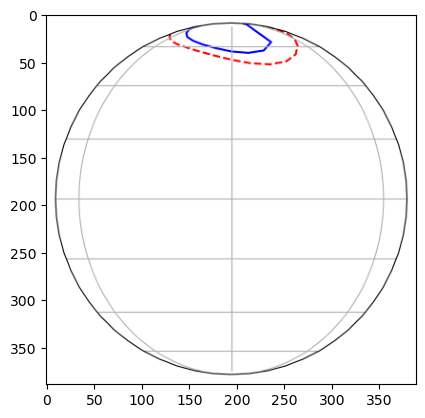

In [192]:
from PIL import Image
import matplotlib.image as mpimg

mscan2 = Image.open(plot_dir + "/model_scan_2.png")
mscan2 = mscan2.resize((389, 389), resample=0)
pscan2 = mpimg.imread(plot_dir + "/polar_scan_2.png")

data_crs = ccrs.PlateCarree()

# plt.imshow(mscan2[25:938,25:938,:])
plt.figure()
# ax = plt.axes(projection=ccrs.Orthographic(180,0))
# plt.imshow(np.array(mscan2), alpha=1)
# ax.set_global()

plt.imshow(pscan2, alpha=1)
# ax.plot(360-main_oval_long, main_oval_lat, transform=data_crs, c='b', ls='-')

# plt.plot(456,456, ms=5, c='orange', marker='*')
# plt.imshow(h3p_div, origin='lower')

In [164]:
for p in range(0, 189):
    print(slit_to_lat_long(0, p, r, seangle, posangle, 180))

(array([-2.66160163, -3.53437954, -3.53437954, -2.66160163,  0.        ]), array([179.91314464, 179.91310062, 180.08689938, 180.08685536,
         0.        ]))
(array([-2.35854037, -3.23133049, -3.23133049, -2.35854037, -2.79495363]), array([179.9131552, 179.9131182, 180.0868818, 180.0868448, 180.       ]))
(array([-2.05545842, -2.92828517, -2.92828517, -2.05545842, -2.49189878]), array([179.91316333, 179.91313333, 180.08686667, 180.08683667,
       180.        ]))
(array([-1.75234728, -2.6252351 , -2.6252351 , -1.75234728, -2.18882698]), array([179.91316903, 179.91314604, 180.08685396, 180.08683097,
       180.        ]))
(array([-1.44919848, -2.3221718 , -2.3221718 , -1.44919848, -1.88572973]), array([179.9131723 , 179.91315631, 180.08684369, 180.0868277 ,
       180.        ]))
(array([-1.14600349, -2.01908679, -2.01908679, -1.14600349, -1.58259854]), array([179.91317314, 179.91316415, 180.08683585, 180.08682686,
       180.        ]))
(array([-0.84275382, -1.71597158, -1.71597158,

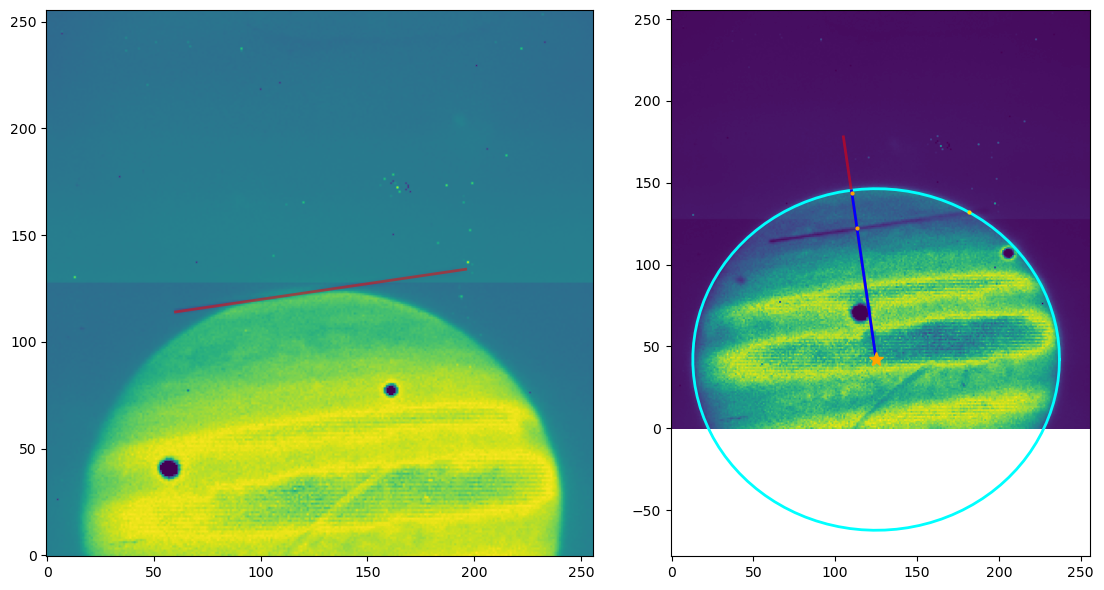

In [29]:
scam = os.path.abspath("./../../scam") + "/"

top = fits.open(scam + "/jun02i0394.fits", ignore_missing_end=True)[0].data
bot = fits.open(scam + "/jun02i0768.fits", ignore_missing_end=True)[0].data

flattening = 0.06487
losflattening = flattening * (1 - np.sin(np.deg2rad(-3.098)))
eq_po_ratio = 1 - losflattening

u2 = 125  # x-position of the center
v2 = 42  # y-position of the center
a2 = 112  # radius on the x-axis
b2 = 112 * eq_po_ratio

t = np.linspace(0, 2 * np.pi, 100)

fig = plt.figure(figsize=(12, 6), tight_layout=True)

fig.add_subplot(121)
plt.imshow(top, origin="lower", norm=PowerNorm(gamma=0.3))
plt.plot([60, 196], [114, 134], "r-", lw=2, alpha=0.5)

fig.add_subplot(122)
plt.imshow(bot, origin="lower", norm=PowerNorm(gamma=1))
plt.plot(u2 + a2 * np.cos(t), v2 + b2 * np.sin(t), "cyan", lw=2)
plt.plot([60, 196], [114, 134], "r-", lw=2, alpha=0.5)
plt.plot([60, 196], [136, 156], "r-", lw=2, alpha=0.5)
plt.plot([136 - 31, 156 - 31], [196 - 18, 60 - 18], "r-", lw=2, alpha=0.5)
plt.plot([136 - 31 + 5, 156 - 31], [196 - 18 - 33, 60 - 18], "b-", lw=2, alpha=1)
plt.plot(125, 42, ms=10, c="orange", marker="*")
plt.plot(113.1, 122.1, ms=4, c="orange", marker=".")
plt.plot(110, 143.5, ms=4, c="orange", marker=".")
plt.plot(182, 132, ms=4, c="gold", marker=".")

In [ ]:
x = 110
y = 143.5

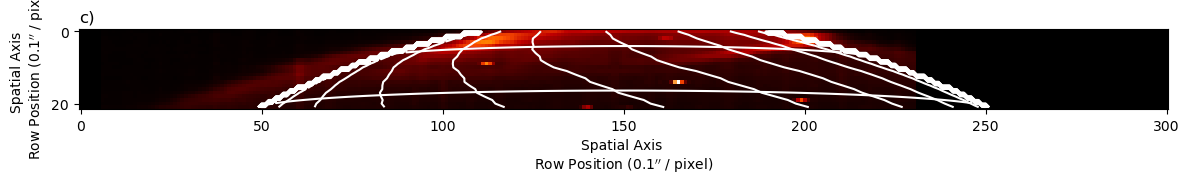

In [187]:
cmlsel = read_csv("cml-sel.txt", sep="\s+", header=None)
cml = cmlsel[3].to_numpy()
seangle = -3.098  # needed
ang_diam = 40.58867
r = ang_diam / (0.1) / 2
posangle = 0

new_lat = backgr_shifted[16:] * 0
new_long = backgr_shifted[16:] * 0

ypos = np.linspace(185, 185 - 21, 22)
xpos = np.linspace(-150, 150, 301)


for x in range(len(xpos)):
    for y in range(len(ypos)):
        latit, longit = slit_to_lat_long(
            xpos[x], ypos[y], r, seangle, posangle, cml[16:][y]
        )
        new_lat[y, x] = latit[4]
        new_long[y, x] = longit[4]

fig = plt.figure(figsize=(12, 6), tight_layout=True)

# fig.add_subplot(211)
# plt.imshow(reback, aspect='equal', cmap='gist_heat', norm=colors.PowerNorm(gamma=1))
# # plt.imshow(backgr_shifted, aspect='equal', cmap='gist_heat', norm=colors.PowerNorm(gamma=1))
# # plt.plot(u+a*np.cos(t) , v+b*np.sin(t), 'cyan', lw=2)
# # plt.plot(u2+a2*np.cos(t) , v2+b2*np.sin(t), 'cyan', lw=2)
# plt.xlabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ / pixel)')#x coordinate
# plt.ylabel('Temporal Axis \nRow Position (0.1$^{\prime\prime}$ / pixel)')#polar pixel radius y coordinate
# plt.title('c)', loc='left')

fig.add_subplot(212)
plt.imshow(
    backgr_shifted[16:],
    aspect="equal",
    cmap="gist_heat",
    interpolation="none",
    #            extent=[-150, 150, 145.0669, 189.0669],
    norm=PowerNorm(gamma=1),
    #            origin='lower',
)
plt.xlabel("Spatial Axis \nRow Position (0.1$^{\prime\prime}$ / pixel)")  # x coordinate
plt.ylabel(
    "Spatial Axis \nRow Position (0.1$^{\prime\prime}$ / pixel)"
)  # polar pixel radius y coordinate
plt.title("c)", loc="left")


# plt.imshow(np.degrees(new_lat))
# plt.colorbar()
plt.contour(
    new_lat,
    np.linspace(-90, 90, 19),
    colors="white",
    #             extent=[-150, 150, 145.0669, 189.0669],
)
# plt.contour(np.degrees(new_long),
#             np.linspace(0,360,25),
#             colors='gray',
#             extent=[-150, 150, 145.0669, 189.0669],
#            )
plt.contour(
    new_long,
    np.linspace(0, 360, 25),
    colors="white",
    #             extent=[-150, 150, 145.0669, 189.0669],
)

# hdu1 = fits.PrimaryHDU(bgrss2)
# hdu1.writeto('ref_sun.fits', overwrite=True)

# hdu2 = fits.PrimaryHDU(np.degrees(new_lat))
# hdu2.writeto('latit.fits', overwrite=True)

# hdu3 = fits.PrimaryHDU(np.degrees(new_long))
# hdu3.writeto('longit.fits', overwrite=True)

(0.0, 1010.0)

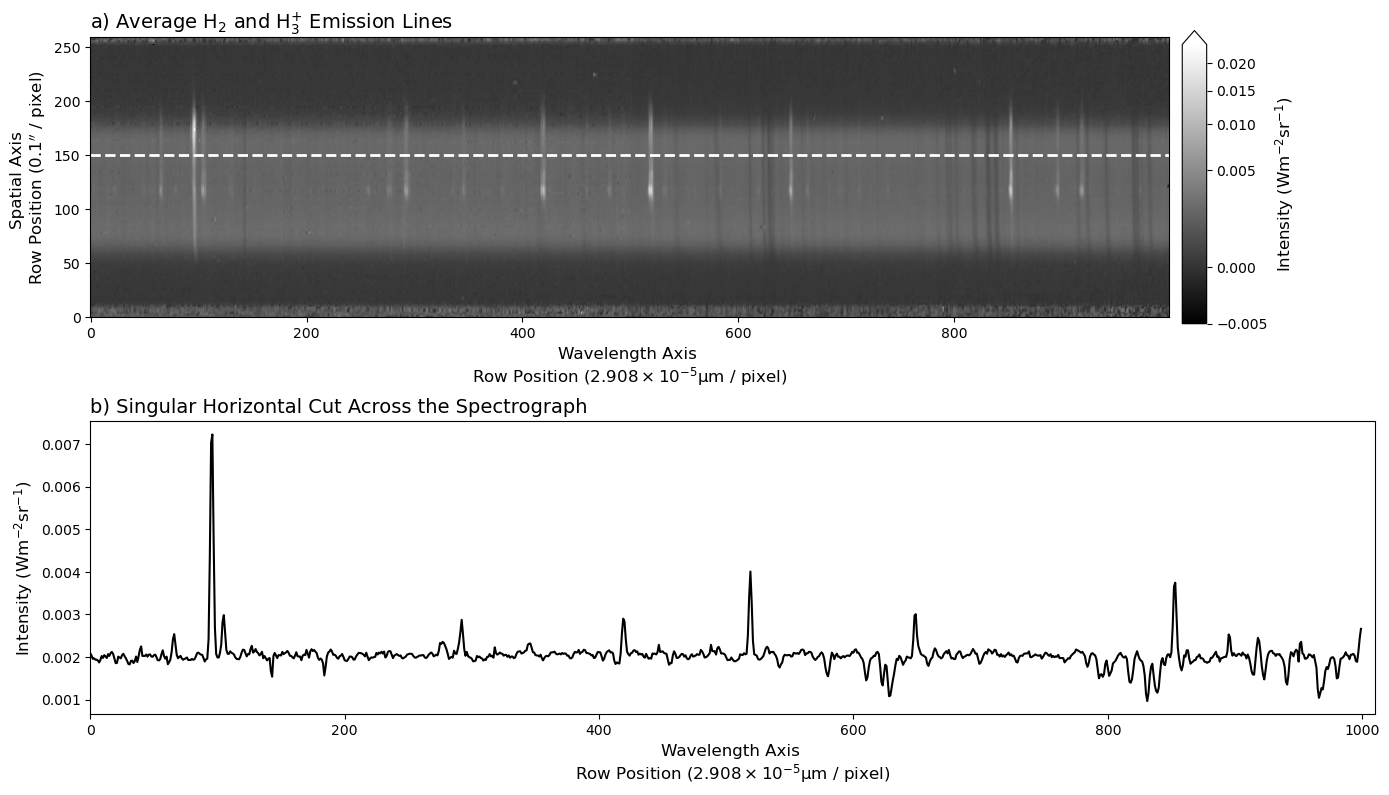

In [2]:
fig = plt.figure(figsize=(14, 8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(
    fjc36_rs[1][:, :1000],
    aspect="equal",
    interpolation="none",
    cmap="gist_gray",
    norm=PowerNorm(gamma=0.4),
)
plt.axhline(y=150, c="white", ls="--", lw=2)
plt.xlabel(
    "Wavelength Axis \nRow Position "
    + r"($2.908 \times 10^{-5} \mathrm{\mu}$m / pixel)",
    fontsize=12,
)
plt.ylabel("Spatial Axis \nRow Position (0.1$^{\prime\prime}$ / pixel)", fontsize=12)
plt.title("a) Average H$_2$ and H$_3^{+}$ Emission Lines", loc="left", fontsize=14)
plt.gca().invert_yaxis()
plt.colorbar(extend="max", aspect=12, pad=0.01).set_label(
    label="Intensity (Wm$^{-2}$sr$^{-1}$)", size=12
)
# plt.savefig('obs1', dpi=400, bbox_inches='tight', facecolor='white')

# fig = plt.figure(figsize=(10,9), tight_layout=True)

fig.add_subplot(212)
plt.plot(fjc36_rs[1][150][:1000], "k-")
plt.xlabel(
    "Wavelength Axis \nRow Position "
    + r"($2.908 \times 10^{-5} \mathrm{\mu}$m / pixel)",
    fontsize=12,
)
plt.ylabel("Intensity (Wm$^{-2}$sr$^{-1}$)", fontsize=12)
plt.title("b) Singular Horizontal Cut Across the Spectrograph", loc="left", fontsize=14)
plt.xlim(0, 1010)
# plt.savefig('obs2', dpi=400, bbox_inches='tight', facecolor='white')

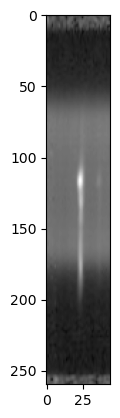

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 66
    # data points      = 45
    # variables        = 6
    chi-square         = 2.4915e-08
    reduced chi-square = 6.3885e-10
    Akaike info crit   = -947.150586
    Bayesian info crit = -936.310612
[[Variables]]
    a0:  9.9030e-04 +/- 2.2360e-05 (2.26%) (init = 0.002)
    a1:  23.9391097 +/- 0.02887504 (0.12%) (init = 22)
    a2:  1.36882989 +/- 0.02473495 (1.81%) (init = 2)
    a3:  9.9285e-04 +/- 1.1095e-05 (1.12%) (init = 0)
    a4: -2.8831e-07 +/- 1.2556e-06 (435.51%) (init = 0)
    a5:  4.0029e-08 +/- 2.7583e-08 (68.91%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(a4, a5) = -0.973
    C(a3, a4) = -0.849
    C(a3, a5) =  0.737
    C(a0, a2) = -0.456
    C(a2, a4) = -0.268
    C(a2, a5) =  0.267


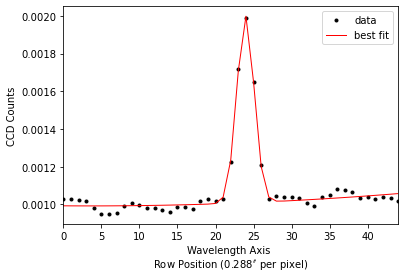

In [32]:
xx = np.linspace(0, 44, 45)

gmodel = Model(gaussian_fit)

gparams = gmodel.make_params()
gparams.add("a0", value=0.002)
gparams.add("a1", value=22)
gparams.add("a2", value=2)
gparams.add("a3", value=0)
gparams.add("a4", value=0)
gparams.add("a5", value=0)

gresult = gmodel.fit(ss2[150], gparams, x=xx)

print(fit_report(gresult, min_correl=0.25))

plt.figure()
plt.plot(xx, ss2[150], "k.", label="data")
plt.plot(xx, gresult.best_fit, "r-", lw=1, label="best fit")
plt.xlim(0, 44)
plt.xlabel("Wavelength Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)")
plt.ylabel("CCD Counts")
plt.legend()

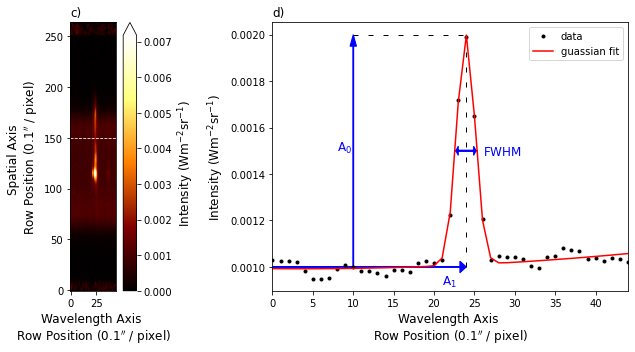

In [122]:
fig = plt.figure(figsize=(12, 5), tight_layout=True)

fig.add_subplot(121)
plt.imshow(ss2, aspect="equal", interpolation="none", cmap="afmhot")
plt.axhline(y=150, c="white", ls="--", lw=0.8)
plt.xlabel("Wavelength Axis \nRow Position (0.1$^{\prime\prime}$ / pixel)", fontsize=12)
plt.ylabel("Spatial Axis \nRow Position (0.1$^{\prime\prime}$ / pixel)", fontsize=12)
plt.title("c)", loc="left")
plt.gca().invert_yaxis()
# plt.colorbar(extend='max', label='Intensity (Wm$^{-2}$sr$^{-1}$)')
plt.colorbar(extend="max", aspect=20, pad=0.02, fraction=0.05).set_label(
    label="Intensity (Wm$^{-2}$sr$^{-1}$)", size=12
)

fig.add_subplot(122)
plt.plot(
    [23.93, 23.93], [0.001, 0.002], color="k", linestyle="--", dashes=(5, 10), lw=1
)
plt.plot([10, 24], [0.002, 0.002], color="k", linestyle="--", dashes=(5, 10), lw=1)
# plt.plot([20, 20], [0.04, 0.16], color='b', linestyle='-', lw=1)
plt.arrow(
    10,
    0.001,
    0,
    0.001,
    head_width=0.8,
    head_length=0.00005,
    width=0.1,
    fc="b",
    ec="b",
    length_includes_head=True,
)
plt.arrow(
    0,
    0.001,
    24,
    0,
    head_width=0.00005,
    head_length=0.8,
    width=0.000004,
    fc="b",
    ec="b",
    length_includes_head=True,
)
plt.arrow(
    22.65,
    0.0015,
    2.55,
    0,
    head_width=0.00004,
    head_length=0.3,
    width=0.000004,
    fc="b",
    ec="b",
    length_includes_head=True,
)
plt.arrow(
    25.35,
    0.0015,
    -2.65,
    0,
    head_width=0.00004,
    head_length=0.3,
    width=0.000004,
    fc="b",
    ec="b",
    length_includes_head=True,
)
plt.text(8, 0.0015, "$\mathrm{A_0}$", color="b", fontsize=12)
plt.text(21, 0.00092, "$\mathrm{A_1}$", color="b", fontsize=12)
plt.text(26, 0.00148, "$\mathrm{FWHM}$", color="b", fontsize=12)
plt.plot(xx, ss2[150], "k.", label="data")
plt.plot(xx, gresult.best_fit, "r-", lw=1.5, label="guassian fit")
plt.xlim(0, 44)
plt.xlabel("Wavelength Axis \nRow Position (0.1$^{\prime\prime}$ / pixel)", fontsize=12)
plt.ylabel("Intensity (Wm$^{-2}$sr$^{-1}$)", fontsize=12)
plt.title("d)", loc="left")
plt.legend()

plt.savefig("gaussian_fit", dpi=400, bbox_inches="tight", facecolor="white")

[117.] [184.]
150.5
[103.] [197.]
150.0
[100.] [202.]
151.0


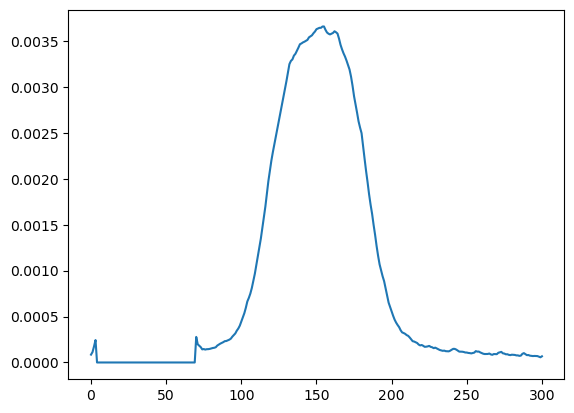

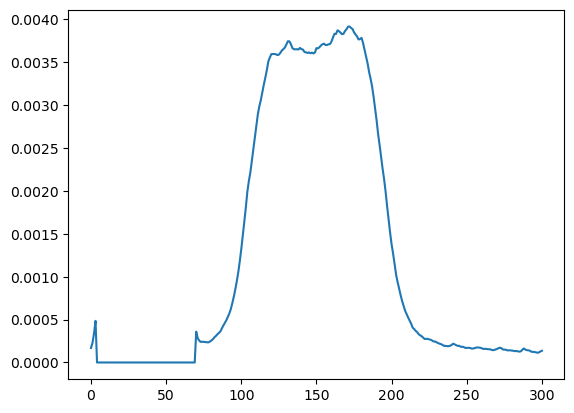

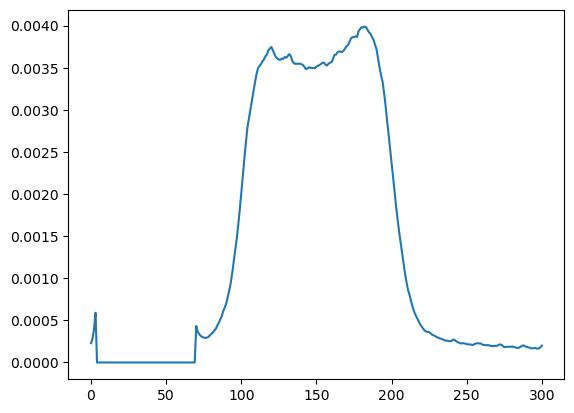

In [27]:
for i in range(16, 19):
    limbs = backgr_shifted[i, :]
    plt.figure()
    plt.plot(limbs)

    limbs[limbs < np.amax(limbs) * 0.3] = np.amax(limbs) * 0.3
    limbs[limbs > np.amax(limbs) * 0.6] = np.amax(limbs) * 0.6

    peak = np.linspace(0, 299, 300)[
        np.where(np.gradient(limbs) == np.max(np.gradient(limbs)))
    ]
    trough = np.linspace(0, 299, 300)[
        np.where(np.gradient(limbs) == np.min(np.gradient(limbs)))
    ]

    print(peak, trough)
    print((float(peak) + float(trough)) / 2)

In [224]:
# backgr_raw = np.vstack(background_scan)

# backgr_shifted = np.vstack((backgr1,backgr2,backgr3,backgr4,backgr5))

# for i in range(16):
#     backgr_shifted[i,:] = scipy.ndimage.shift(backgr_shifted[i,:], i*6, order=3)

backgr_shifted = np.flip(backgr_shifted, axis=1)

for i in range(5):
    limbs = backgr_shifted[i, :]
    #     plt.figure()
    #     plt.plot(limbs)

    limbs[limbs < np.amax(limbs) * 0.2] = np.amax(limbs) * 0.2
    limbs[limbs > np.amax(limbs) * 0.6] = np.amax(limbs) * 0.6

    peak = np.linspace(0, 299, 300)[
        np.where(np.gradient(limbs) == np.max(np.gradient(limbs)))
    ]
    trough = np.linspace(0, 299, 300)[
        np.where(np.gradient(limbs) == np.min(np.gradient(limbs)))
    ]

    print(peak, trough)
    print((float(peak) + float(trough)) / 2)


#     plt.figure()
#     plt.plot(limbs)
#     plt.figure()
#     plt.plot(np.gradient(limbs))

[100.] [193.]
146.5
[92.] [202.]
147.0
[85.] [210.]
147.5
[78.] [217.]
147.5
[68.] [220.]
144.0


In [12]:
hdu = fits.PrimaryHDU(backgr_shifted)
hdu.writeto("ref_sun.fits", overwrite=True)

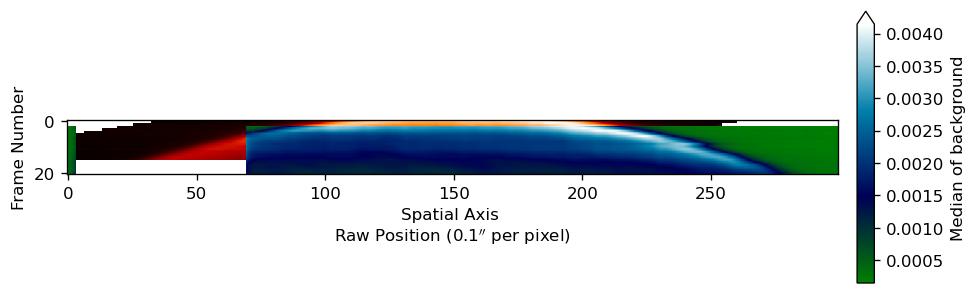

In [219]:
t1 = np.delete(backgr_shifted, np.s_[16:], 0)
t1 = np.vstack((t1, np.zeros((5, 300))))
t2 = np.delete(backgr_shifted, np.s_[:19], 0)
t2 = np.vstack((np.zeros((2, 300)), t2))

t1[t1 < 1e-5] = np.nan
t2[t2 < 1e-5] = np.nan

plt.figure(figsize=(10, 3))
plt.imshow(t1, cmap="gist_heat", norm=colors.PowerNorm(gamma=1), alpha=1)
plt.imshow(t2, cmap="ocean", norm=colors.PowerNorm(gamma=1), alpha=1)
plt.xlabel("Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)")
plt.ylabel("Frame Number")
# plt.title(r'a) H$_2$($\lambda$$\approx$' + str(round(waverange[96], 4)) + '$\mu$m)', loc='left')
plt.colorbar(extend="max", aspect=15, pad=0.02, label="Median of background")